# Tornado Plot Example

## Load Packages / Settings

In [1]:
# Plotting packages
from plotnine import *
import matplotlib.pyplot as plt

# For mathematical operations
import numpy as np
import pandas as pd
import random 


# For clearer visualization in the notebook (mac only)
%config InlineBackend.figure_format ='retina'

# Unit conversion parameters 
SEC_PER_DAY = 24*60*60

## Variables for plotting example
Some of these variables are needed to just setup the analysis result for this example.

In [2]:
# Parameters to scan
param_to_scan = ['Kd_nM',  'R_nM', 'V_L', 'drug_half_life', 'receptor_half_life' ]
# Descriptions of parameters to scan (in the same order)
descriptions = ['Receptor Binding affinity (nM)', 
                'Receptor Burden (nM)', 
                'Central Volume (L)',
                'Drug half life (days)',
                'Receptor half life (hours)']
# Dictionary of parameters and descriptions
param_descrxn = {param:descrxn for param,descrxn in zip(param_to_scan, descriptions)}
param_descrxn

# Other information for plotting
fold_change = 10
output_name = 'Random output'
units = '1/s'

## Create example output of combined scan scenarios
This recreates an output that should be similar to a Scan output when using the `psf`.

In [3]:
param_num = len(param_to_scan)
random_nominal = random.randrange(0, 100)
random_results = [random.randrange(0, 100) for x in range(param_num*2)]
[random_results.insert(b*3,random_nominal) for b in range(0, param_num)]
synth_analysis_results = pd.DataFrame(data = {'value': random_results,
                                    'scan_0_fold': [1, 1/fold_change, fold_change]*param_num,
                                    'param_scan_0': [x for x in param_to_scan for i in range(3)]})

synth_analysis_results['description'] = synth_analysis_results.apply(lambda x: param_descrxn[x.param_scan_0], axis=1)
synth_analysis_results


,value,scan_0_fold,param_scan_0,description
0,29,1.0,Kd_nM,Receptor Binding affinity (nM)
1,74,0.1,Kd_nM,Receptor Binding affinity (nM)
2,81,10.0,Kd_nM,Receptor Binding affinity (nM)
3,29,1.0,R_nM,Receptor Burden (nM)
4,98,0.1,R_nM,Receptor Burden (nM)
5,67,10.0,R_nM,Receptor Burden (nM)
6,29,1.0,V_L,Central Volume (L)
7,12,0.1,V_L,Central Volume (L)
8,18,10.0,V_L,Central Volume (L)
9,29,1.0,drug_half_life,Drug half life (days)


# Plot using `matplotlib`

## Rearranging Scan output for plotting
The function that orders the rows of a tornado plot requires a compact format of the results for easier manipulation.

In [4]:
segment_data = synth_analysis_results.pivot(index="param_scan_0", columns="scan_0_fold", values="value")
segment_data = segment_data.reset_index()
segment_data.columns = ['param_scan_0', 'minimum', 'nominal', 'maximum']
segment_data = segment_data.assign(description = [param_descrxn[x] for x in segment_data.param_scan_0])
segment_data

,param_scan_0,minimum,nominal,maximum,description
0,Kd_nM,74,29,81,Receptor Binding affinity (nM)
1,R_nM,98,29,67,Receptor Burden (nM)
2,V_L,12,29,18,Central Volume (L)
3,drug_half_life,85,29,32,Drug half life (days)
4,receptor_half_life,78,29,10,Receptor half life (hours)


## Order output values

In [5]:
def tornado_order_parameter_scans(segment_data):
    '''
    Orders scan simulation output for appropriate ordering in the tornado plot.
    
    Parameters
    ----------
    segment_data : pandas df that has been organized so that each row has all scanned 
           outputs for an individual parameter.
           
    Output
    ------
    segment_data : reorganized input df with additional columns calculating scanned 
           output values' difference from nominal value.
    '''

    # Get differences from nominal value
    segment_data = segment_data.assign(delta_min = segment_data['minimum'] - segment_data['nominal'])
    segment_data = segment_data.assign(delta_max = segment_data['maximum'] - segment_data['nominal'])

    # Get max difference if up/down scans resulted in the same directional change
    same_diff = segment_data.loc[((segment_data['delta_min'] > 0) & (segment_data['delta_max'] > 0)) | ((segment_data['delta_min'] < 0) & (segment_data['delta_max'] < 0))] #
    same_diff = same_diff.assign(total_diff = same_diff[['delta_min','delta_max']].abs().max(axis=1))
    
    # Calculate combined difference if up/down scans resulted in the different directional changes
    diff_diff =   segment_data.drop(same_diff.index)
    diff_diff = diff_diff.assign(total_diff = diff_diff['delta_min'].abs() + diff_diff['delta_max'].abs())

    # Sort df by overall differences
    segment_data = pd.concat([same_diff,diff_diff])
    segment_data  = segment_data.sort_values(by=['total_diff'], ascending=True).reset_index(drop=True)

    # Add a categorial column to the df for proper plotting in plotnine
        # Work around since plotnine defaults to plotting in alphabetical order 
        # https://plotnine.readthedocs.io/en/stable/tutorials/miscellaneous-order-plot-series.html
    p_list = segment_data['description'].value_counts().index.tolist()
    p_ordered = pd.Categorical(segment_data['description'], categories=p_list)
    segment_data = segment_data.assign(description = p_ordered) 
    
    return segment_data

In [6]:
ordered_data = tornado_order_parameter_scans(segment_data)
ordered_data

,param_scan_0,minimum,nominal,maximum,description,delta_min,delta_max,total_diff
0,V_L,12,29,18,Central Volume (L),-17,-11,17
1,Kd_nM,74,29,81,Receptor Binding affinity (nM),45,52,52
2,drug_half_life,85,29,32,Drug half life (days),56,3,56
3,receptor_half_life,78,29,10,Receptor half life (hours),49,-19,68
4,R_nM,98,29,67,Receptor Burden (nM),69,38,69


## Matplotlib plot

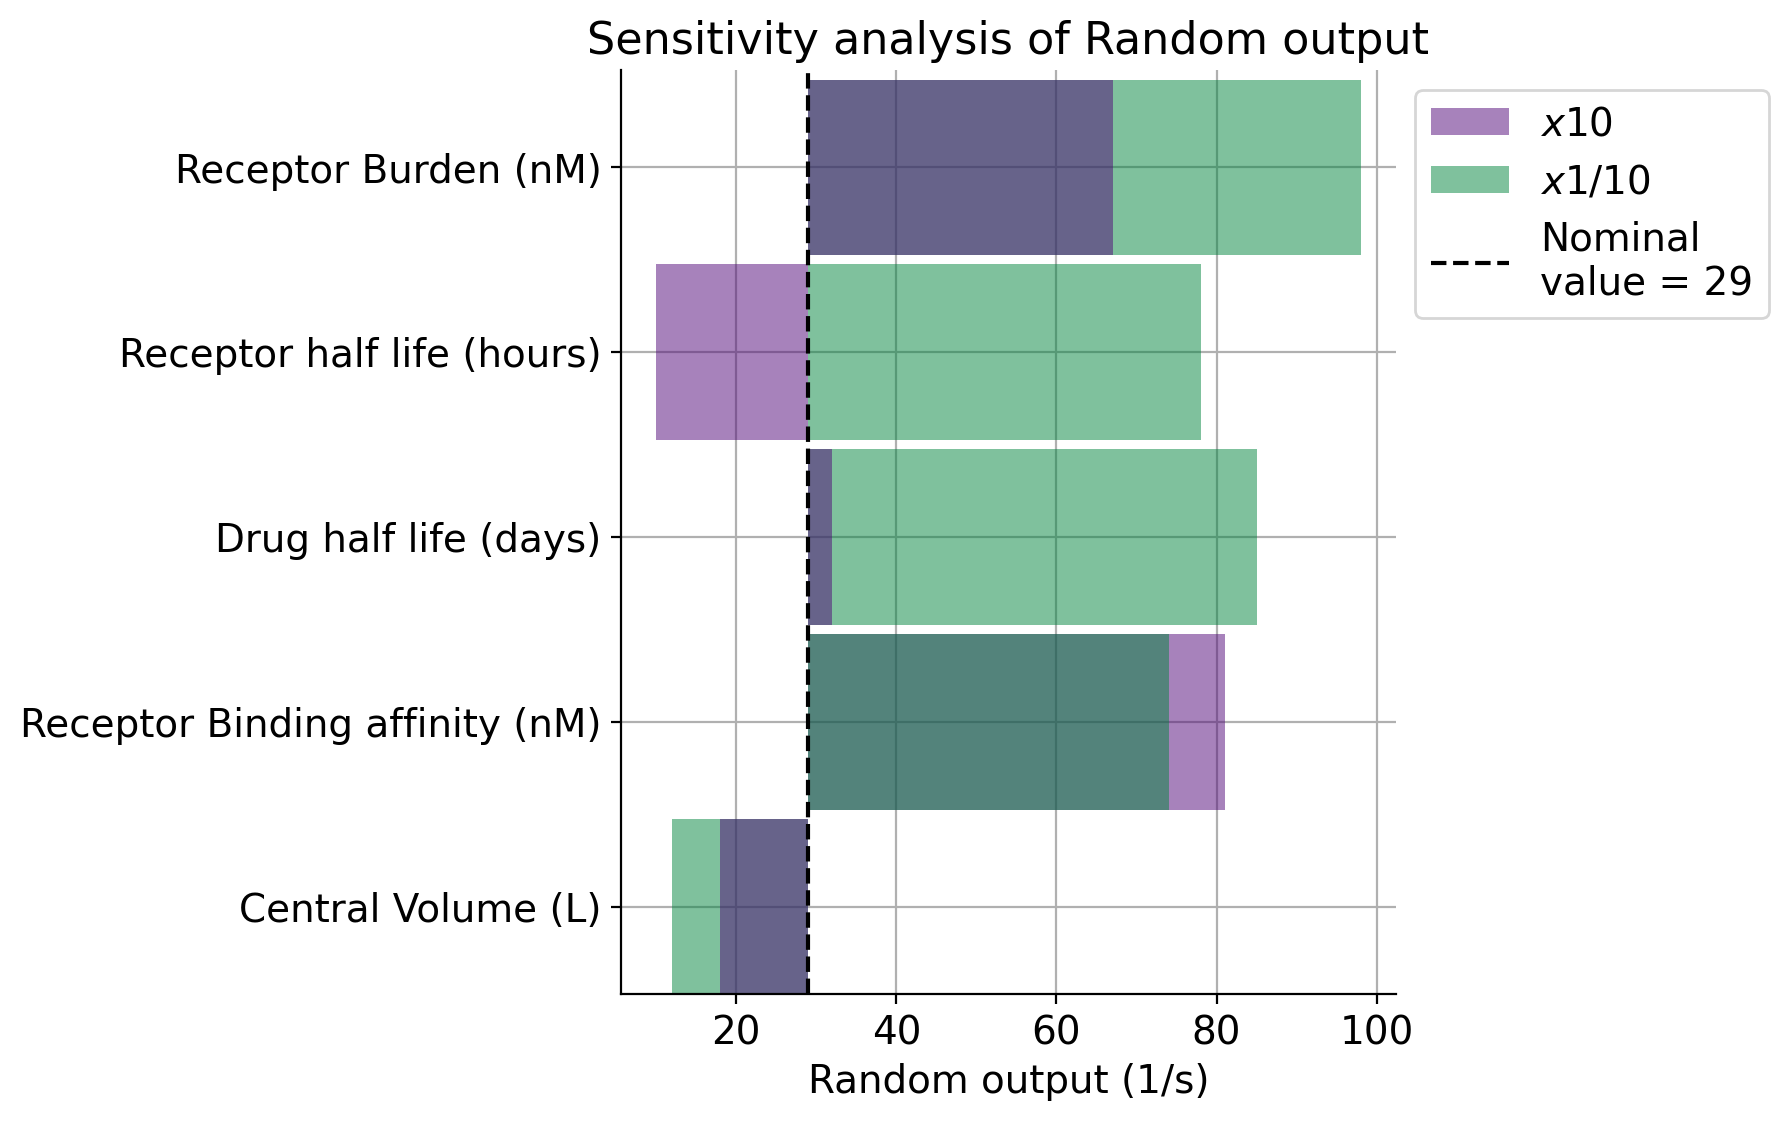

In [7]:
fig, ax = plt.subplots(figsize = (param_num, 6))

height = 0.95

for idx, par in enumerate(ordered_data.param_scan_0):
    par_row = ordered_data[ordered_data["param_scan_0"]==par]
    # If/else for layering smaller diff over larger diff
    if abs(par_row.delta_max.values[0])<abs(par_row.delta_min.values[0]):
        bar1,=ax.barh(idx, left = par_row.nominal, width = par_row.delta_max, 
               color = "#500778", height = height, alpha=0.5, zorder = 2)
        bar2,=ax.barh(idx, left = par_row.nominal, width = par_row.delta_min, 
               color = "#00843D", height = height, alpha=0.5, zorder = 1)
    else:
        bar1,=ax.barh(idx, left = par_row.nominal, width = par_row.delta_max, 
               color = "#500778", height = height, alpha=0.5, zorder = 1)
        bar2,=ax.barh(idx, left = par_row.nominal, width = par_row.delta_min, 
               color = "#00843D", height = height, alpha=0.5, zorder = 2)
        
# Plot nominal line and reset y axis values
ax.set_ylim(0-height/2,param_num-height/2)
plt.vlines(ordered_data.nominal.values[0],0-height/2,param_num-height/2,linestyle='dashed',color='black', label=f'Nominal\nvalue = {round(ordered_data.nominal.values[0],1)}')
ax.set_yticks(np.arange(param_num))
ax.set_yticklabels([param_descrxn[x] for x in ordered_data.param_scan_0], ha = "right", fontsize = 12) #rotation = 60, 

# Plotting settings and labels
bar1.set_label(f'$x{fold_change}$')
bar2.set_label(f"$x 1/{fold_change}$")
ax.legend(bbox_to_anchor=[1,1],fontsize = 14)

ax.set_xlabel(f"{output_name} ({units})", fontsize = 14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_title(f"Sensitivity analysis of {output_name}", fontsize = 16)

ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True)

# Plot using `plotnine`

Using `plotnine` doesn't take as much processing. The below code starts from the simulation output table, which here is called `synth_analysis_results`.

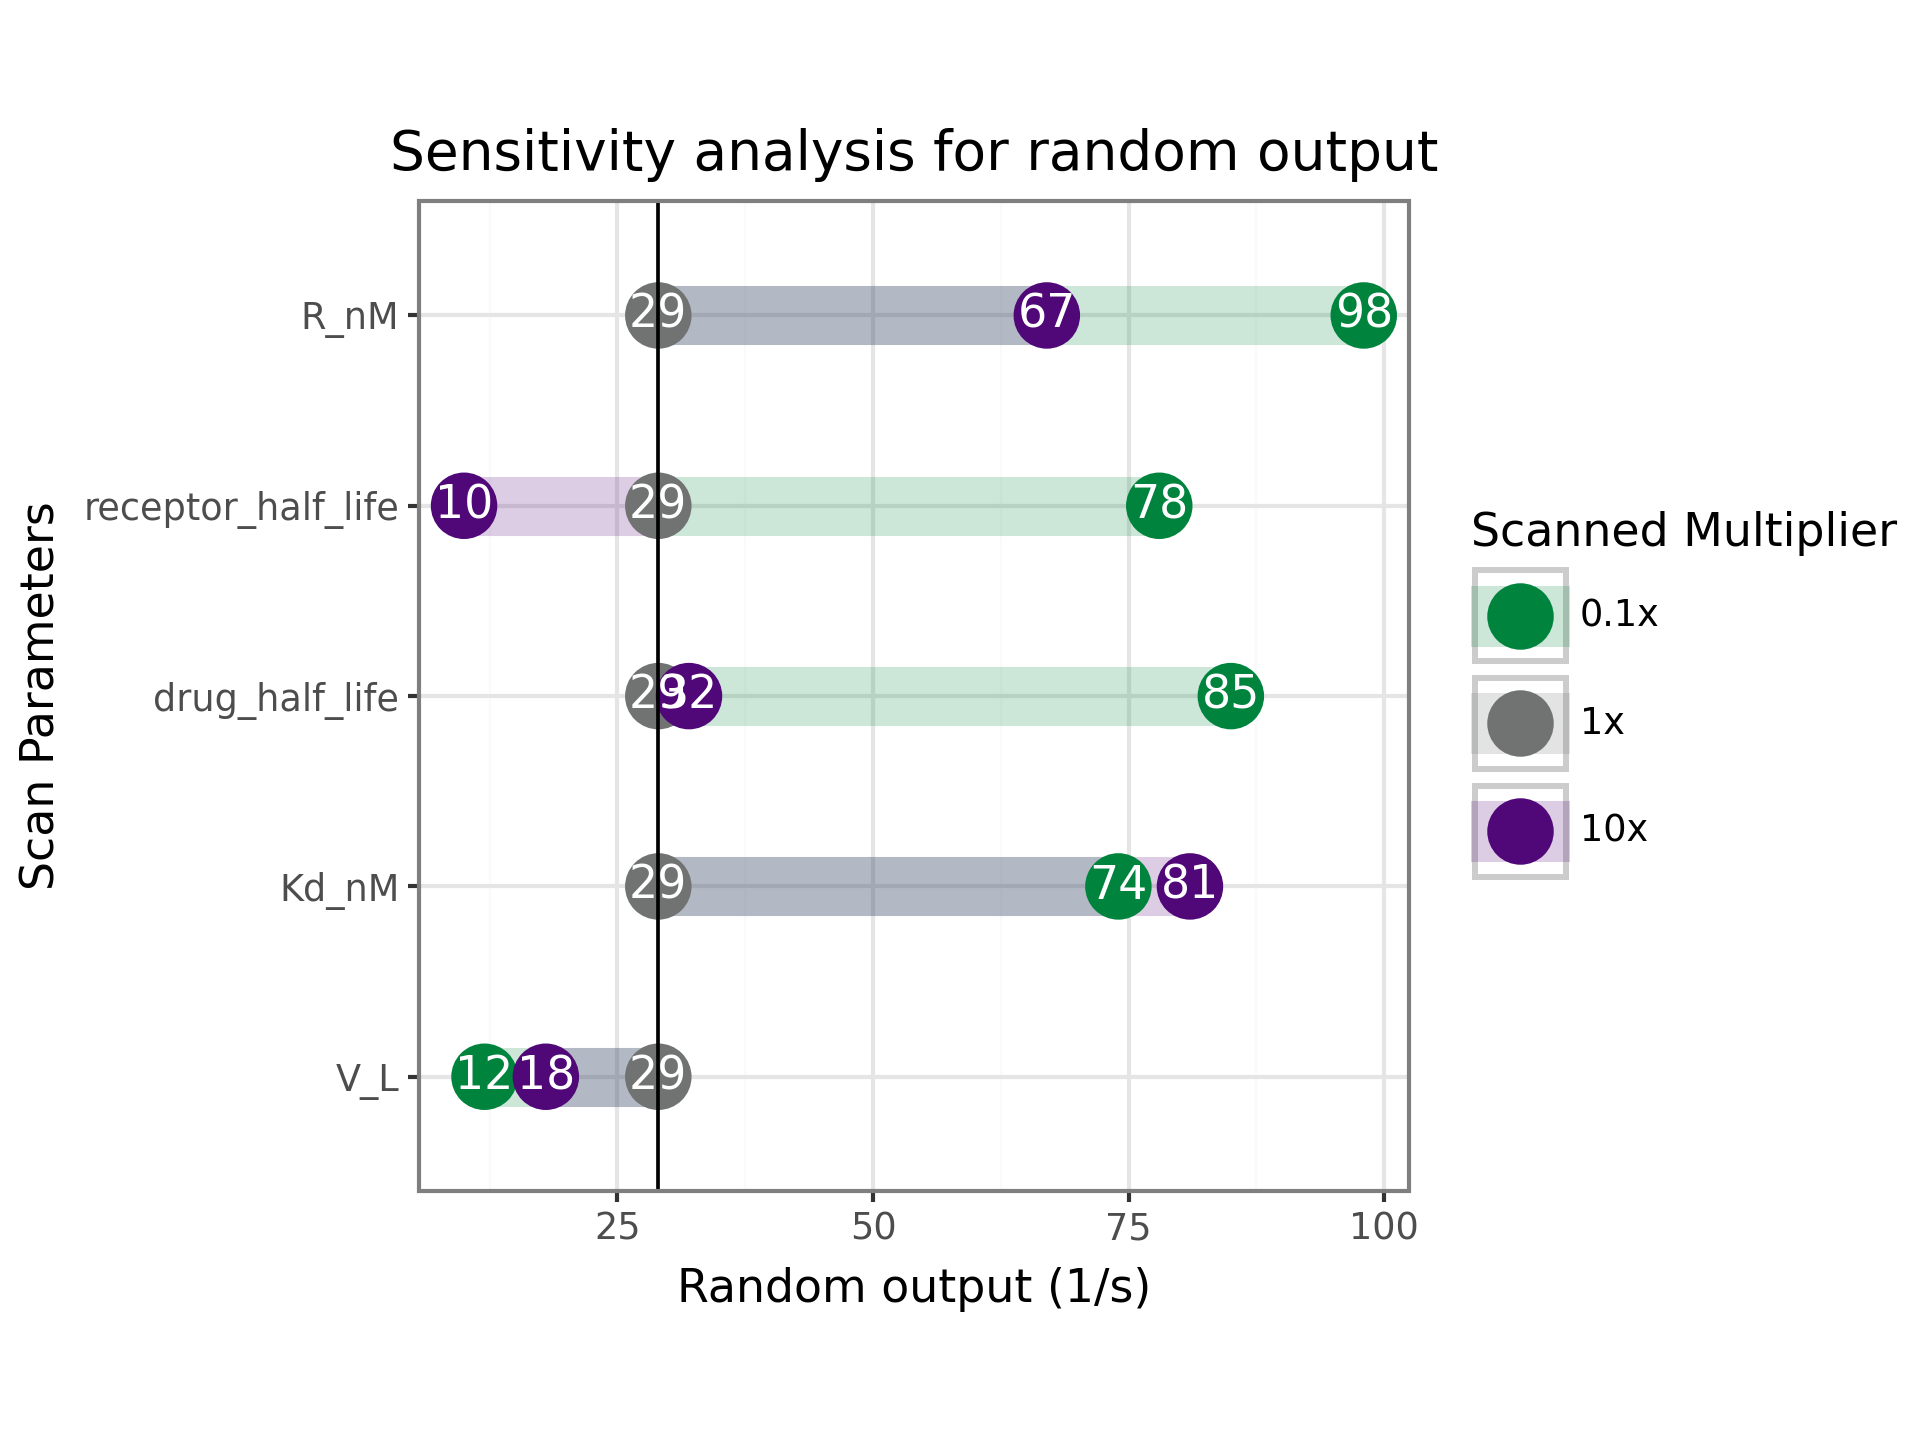

In [8]:
# Get the nominal output value
nominal_value = synth_analysis_results.value[synth_analysis_results.scan_0_fold == 1.][0]

# Get table with parameters ordered as they should appear in the tornado plot
par_ranges = (
    synth_analysis_results
    .groupby('param_scan_0') # For each parameter...
    ['value'] # ...take the value column...
    .apply(lambda val: max(val)-min(val)) # ...and calculate the difference between the max and min value
    .sort_values() # Sort parameters by the result
)
ordered_pars = par_ranges.index.tolist()

# Construct the plot
(
    ggplot(synth_analysis_results)
    
    # Colored segments connecting the points
    + geom_segment(
        aes(x='value', xend='nominal_value', 
            y='param_scan_0', yend='param_scan_0',
            color = 'factor(scan_0_fold)'),
        size = 8, 
        alpha = 0.2
    )
    
    # Points for simulated values
    + geom_point(aes(x='value', y='param_scan_0', color='factor(scan_0_fold)'), size = 8)
    
    # Text for simulated values
    + geom_text(aes(x='value', y='param_scan_0', label='value'), color='white')
    
    # Nominal line
    + geom_vline(xintercept = nominal_value)
    
    # Set colors and their labels
    + scale_color_manual(
        values = ['#00843D', '#707372', '#500778'],
        labels = lambda xs: [f"{xi:g}x" for xi in xs] # Function converts list of numbers to "{number}x"
    )
    
    # Order the parameters for the "tornado" shape
    + scale_y_discrete(limits = ordered_pars) # For a discrete scale, setting limits sets the order of values
    
    + labs(x = "Random output (1/s)", y = "Scan Parameters", color = "Scanned Multiplier",
           title = "Sensitivity analysis for random output")
    + theme_bw()
    + theme(aspect_ratio = 1, dpi=150)
)